In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from openap import WRAP, aero, prop
from feat import (
    FlightProfiles,
    FlightProfileGenerator,
    FuelEstimator,
)

/home/luis/miniconda3/envs/traffic/lib/python3.9/site-packages/feat-0.1-py3.9.egg/feat/flight.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
/home/luis/miniconda3/envs/traffic/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
ac_type = "A320"
wrap = WRAP(ac=ac_type)
wrap.cruise_range(), wrap.cruise_alt(), wrap.cruise_init_alt(), wrap.cruise_mach()

({'default': 856.0,
  'minimum': 487.0,
  'maximum': 4352.0,
  'statmodel': 'gamma',
  'statmodel_params': [1.71, 453.95, 569.12]},
 {'default': 10.92,
  'minimum': 10.0,
  'maximum': 11.84,
  'statmodel': 'norm',
  'statmodel_params': [10.92, 0.56]},
 {'default': 10.82,
  'minimum': 9.79,
  'maximum': 11.85,
  'statmodel': 'norm',
  'statmodel_params': [10.82, 0.63]},
 {'default': 0.78,
  'minimum': 0.75,
  'maximum': 0.8,
  'statmodel': 'beta',
  'statmodel_params': [17.82, 5.05, 0.62, 0.2]})

In [4]:
fpg = FlightProfileGenerator(ac_type="A320")
flight_profiles = fpg.gen_profiles(step=100)
fp_df = flight_profiles.to_df()
fp_df.head()

Flight Profiles:   0%|          | 0/47 [00:00<?, ?it/s]

,t,h,s,v,vs,seg,fp,id
0,0,0.0,0.0,0.0,0.00,None,TO,5
1,30,0.0,0.0,57.9,0.00,TO,TO,5
2,60,0.0,1737.0,115.8,0.00,TO,TO,5
3,90,0.0,5211.0,130.8,12.59,IC,CL,5
4,120,377.7,9135.0,145.8,12.59,IC,CL,5


In [5]:
ranges = [(id, round(fp.s.max() / 1e3)) for id, fp in fp_df.groupby("id")]
ranges = (
    pd.DataFrame.from_records(ranges)
    .rename(columns={0: "id", 1: "range"})
    .sort_values("range")
)
ranges.range.min(), ranges.range.max()

(1084, 4884)

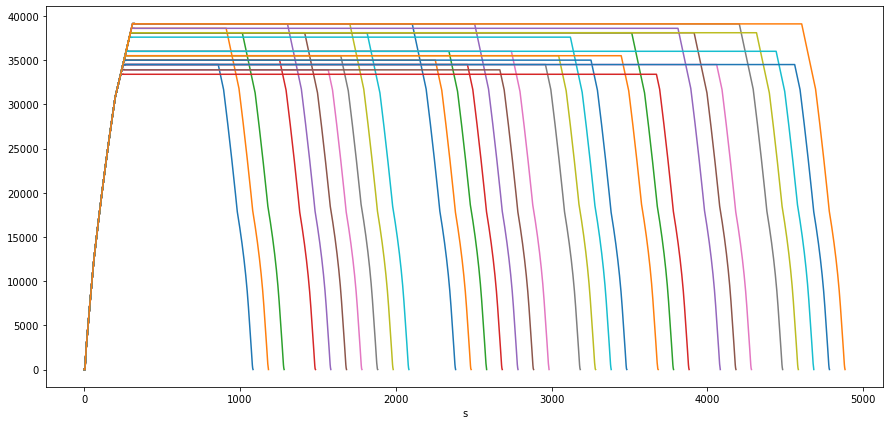

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
for (_, fp) in fp_df.assign(h=fp_df.h / aero.ft, s=fp_df.s / 1e3).groupby("id"):
    fp.plot(x="s", y="h", ax=ax, legend=False)

for i, range_cr in enumerate(
    range(int(wrap.cruise_range()["minimum"]), int(wrap.cruise_range()["maximum"]), 100)
):
    traj = trajs.query(f"id=={i}")
    print(
        range_cr,
        round((traj.query("fp=='CR'").s.max() - traj.query("fp=='CR'").s.min()) / 1e3),
    )

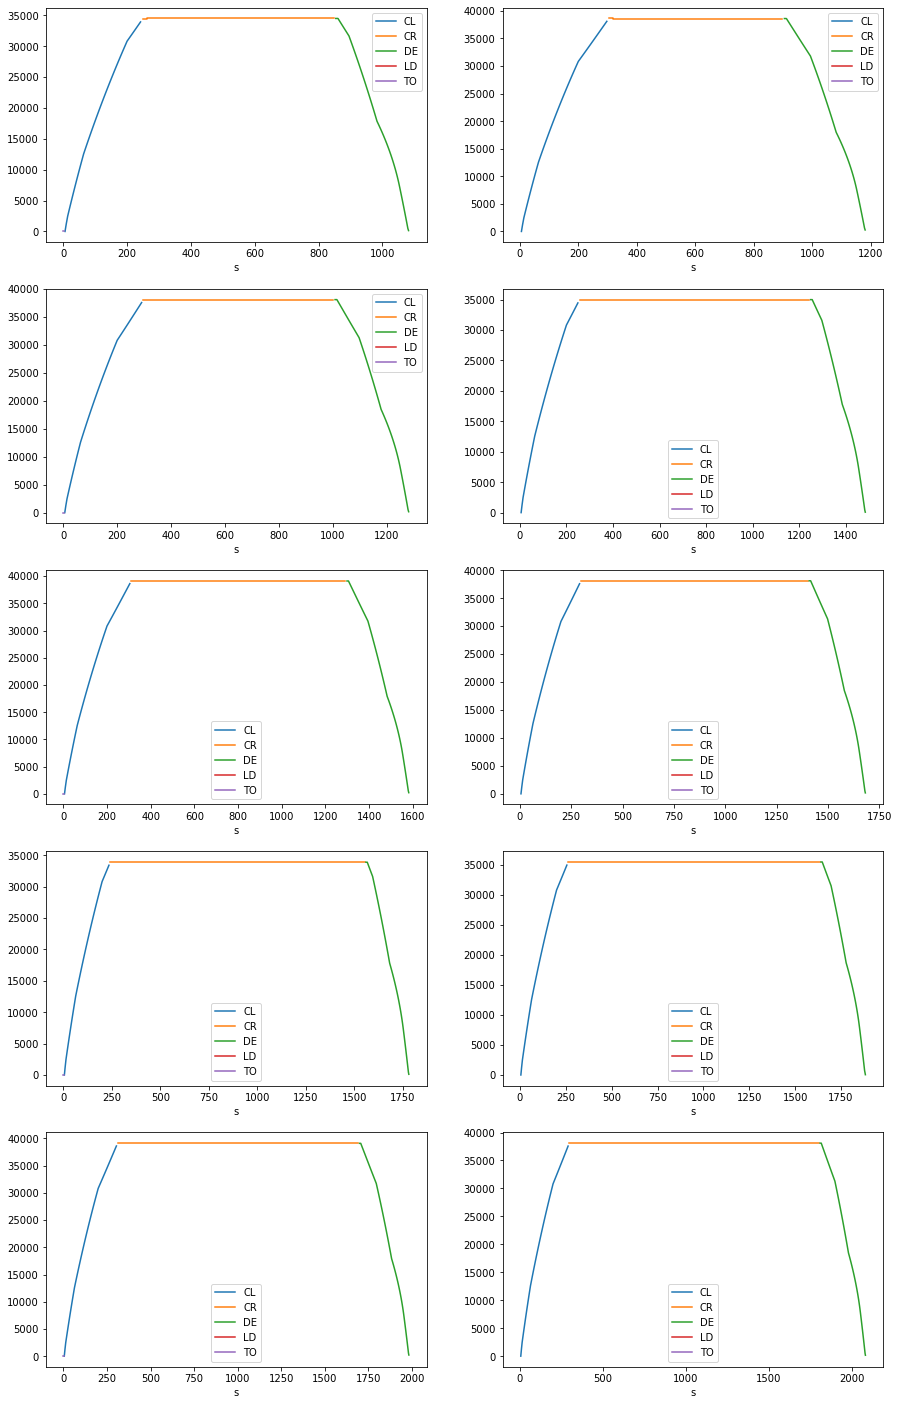

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fprof) in zip(
    axes.flat,
    fp_df.assign(h=fp_df.h / aero.ft, s=fp_df.s / 1e3).groupby("id"),
):
    for fp, fprof_fp in fprof.groupby("fp"):
        fprof_fp.plot(x="s", y="h", ax=ax, label=fp)

In [8]:
fe = FuelEstimator(ac_type=ac_type)
flight_profiles = fe(FlightProfiles.from_df(fp_df))
fp_df = flight_profiles.to_df()
fp_df.head()

Flight profiles:   0%|          | 0/32 [00:00<?, ?it/s]

,t,h,s,v,vs,seg,fp,id,thr,ff,fc,m
0,0,0.0,0.0,0.0,0.00,None,TO,5,0.000000,0.000000,0.000000,62072.666444
1,30,0.0,0.0,57.9,0.00,TO,TO,5,196847.925718,2.713689,81.410655,61991.255788
2,60,0.0,1737.0,115.8,0.00,TO,TO,5,167342.557563,2.185533,146.976654,61925.689790
3,90,0.0,5211.0,130.8,12.59,IC,CL,5,109309.923013,1.354792,187.620401,61885.046043
4,120,377.7,9135.0,145.8,12.59,IC,CL,5,101653.894487,1.278205,225.966546,61846.699898


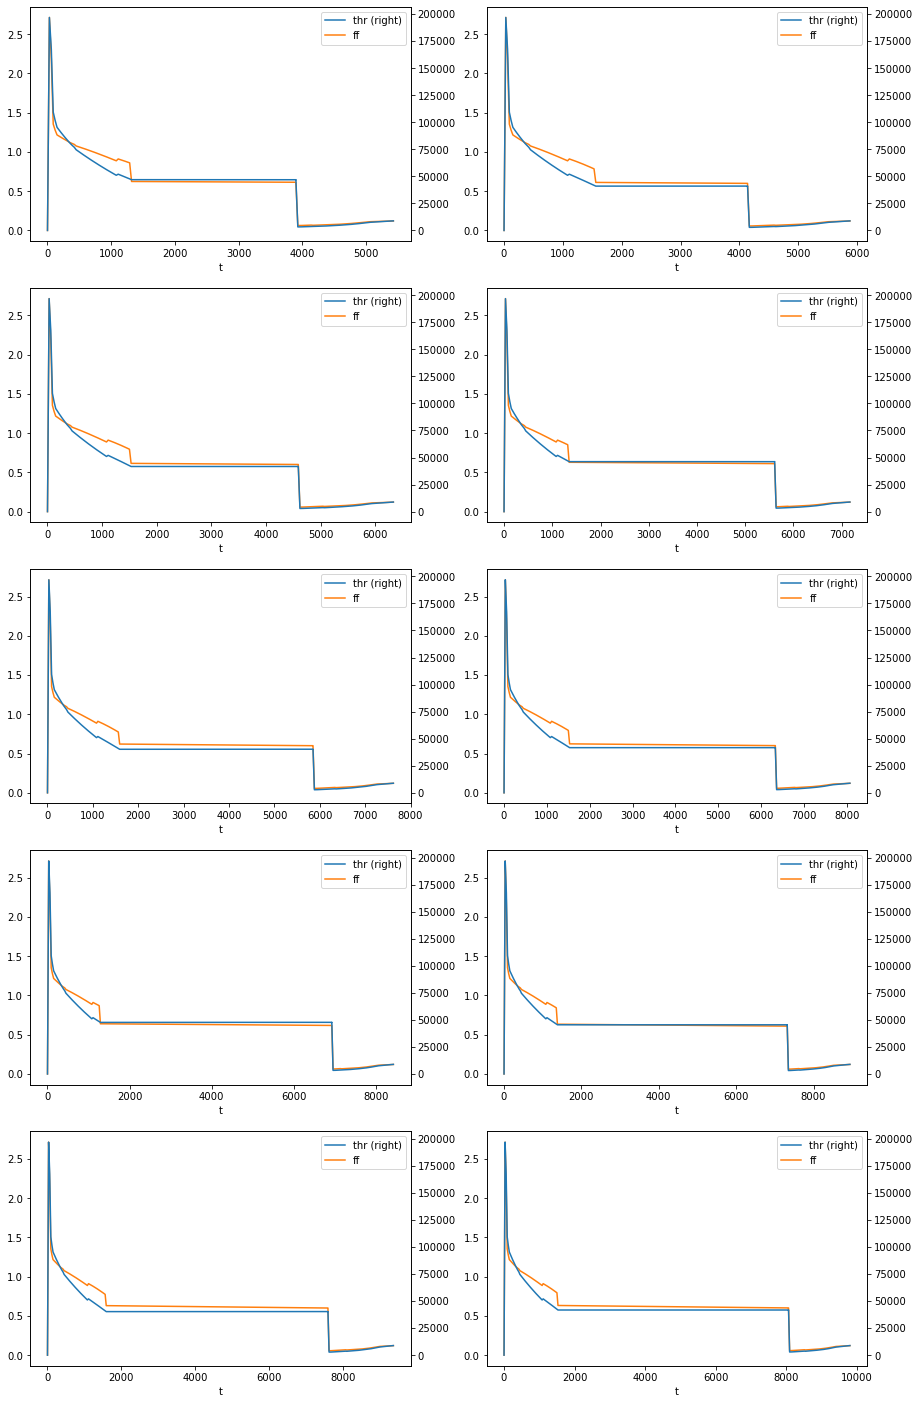

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
for ax, (id, fp) in zip(axes.flat, fp_df.groupby("id")):
    fp.query("ff==ff").plot(
        x="t",
        y=["thr", "ff"],
        secondary_y="thr",
        ax=ax,
        legend=True,
    )

In [10]:
fe = FuelEstimator(ac_type=ac_type)
fc = fe(flight_profiles.from_df(fp_df), last_point=True)
fc_df = fc.to_df()
fc_df.head()

Flight profiles:   0%|          | 0/32 [00:00<?, ?it/s]

,id,fd,fc,m
0,5,1.081963e+06,3159.795874,58912.870570
1,6,1.181069e+06,3334.418512,58922.520653
2,7,1.281566e+06,3608.365228,58936.863764
3,9,1.482758e+06,4231.814566,58968.594237
4,10,1.581243e+06,4396.534435,58978.686921


<AxesSubplot:xlabel='Distance (km)', ylabel='Fuel (Kg)'>

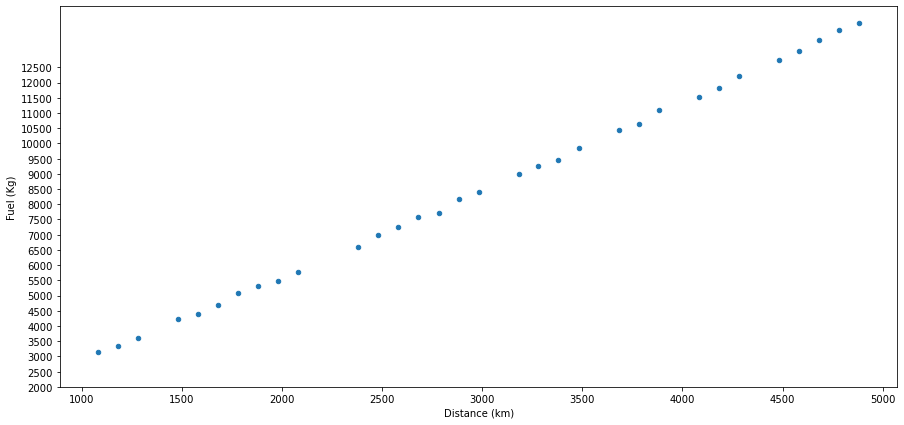

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))
fc_df.assign(fd=fc_df.fd / 1e3).plot.scatter(
    x="fd",
    y="fc",
    ax=ax,
    xlabel="Distance (km)",
    ylabel="Fuel (Kg)",
    yticks=range(2000, 13000, 500),
)

In [12]:
from feat import FeatModelReduction
import pandas as pd

fmr = FeatModelReduction(ac_type)
results = fmr.fit(fc_df.assign(fd=fc_df.fd / 1e3))
results.params

Intercept     231.304256
fd              2.598992
I(fd ** 2)      0.000045
dtype: float64

In [13]:
# 0.00013004233744107196,2.4260951197123437,1310.7950948662055
import statsmodels.formula.api as sm

model = sm.ols(formula="fc ~ fd + I(fd**2)", data=fc_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fc   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.448e+04
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           1.46e-52
Time:                        15:13:30   Log-Likelihood:                -172.93
No. Observations:                  32   AIC:                             351.9
Df Residuals:                      29   BIC:                             356.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    231.3043     70.580      3.277      0.003      86.952     375.657
fd             0.0026   5.16e-05     50.352      0.000       0.002       0.003
I(fd ** 2)  4.452e-11    8.5e-12      5.238      0.000    2.71e-11    6.19e-11
==============================================================================
Omnibus:                        9.660   Durbin-Watson:                   2.502
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                2.385
Skew:                           0.064   Prob(JB):                        0.303
Kurtosis:                       1.669   Cond. No.                     8.74e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.74e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
pd.read_csv("../paper/ac_model_coefficients.csv").query("ac_code_icao=='A320'")[
    ["reduced_fuel_a1", "reduced_fuel_a2", "reduced_fuel_intercept"]
]

,reduced_fuel_a1,reduced_fuel_a2,reduced_fuel_intercept
10,0.00013,2.426095,1310.795095


In [15]:
import numpy as np

model = np.poly1d(np.polyfit(fc_df.fd.values / 1e3, fc_df.fc.values, 2))
model

poly1d([4.45153593e-05, 2.59899224e+00, 2.31304256e+02])

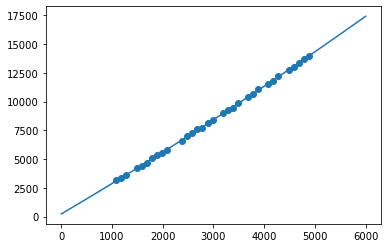

In [16]:
polyline = np.linspace(0, 6000, 100)
plt.scatter(fc_df.fd.values / 1e3, fc_df.fc.values)
plt.plot(polyline, model(polyline))
plt.show()